In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
%matplotlib notebook

In [3]:
def read_metrics(path):
    return h5py.File(Path(path)/"metrics.h5", "r", swmr=True, rdcc_nbytes=1024**3)

In [45]:
def plot_metric(ax, d, name, iqr_ylim=None, legend=True):
    l = np.argmin(d['steps'])
    if l == 0:
        l = len(d['steps'])
    l = min(len(d[name]), l)
    ax.plot(d['steps'][:l], d[name][:l], label=name)
    if legend:
        ax.legend()
    if iqr_ylim is not None:
        all_min, q25, median, q75, all_max = np.nanpercentile(d[name][:l], (0, 25, 50, 75, 100))
        iqr = q75 - q25
        lower = max(median- iqr_ylim*iqr, all_min-0.05*iqr)
        upper = min(median+iqr_ylim*iqr, all_max+0.05*iqr)
        ax.set_ylim((lower, upper))

In [46]:
def plot_metric_exp(ax, d, name, iqr_ylim=None, legend=True):
    l = np.argmin(d['steps'])
    if l == 0:
        l = len(d['steps'])
    l = min(len(d[name]), l)
    ax.plot(d['steps'][:l], np.clip(np.exp(d[name][:l]), 0, 1), label=name)
    if legend:
        ax.legend()
    if iqr_ylim is not None:
        all_min, q25, median, q75, all_max = np.nanpercentile(d[name][:l], (0, 25, 50, 75, 100))
        iqr = q75 - q25
        lower = max(median- iqr_ylim*iqr, all_min-0.05*iqr)
        upper = min(median+iqr_ylim*iqr, all_max+0.05*iqr)
        ax.set_ylim((lower, upper))

In [77]:
def acceptance_vlines(ax, d):
    for i in np.where(d['acceptance/is_sample'][:] == 1)[0]:
        step = d['steps'][i]
        ax.axvline(step, color='red', linestyle="--", linewidth=0.5)

# VerletSGLD metrics

In [62]:
d = read_metrics("/scratch/ag919/logs/BNN-priors/103")
d.keys()

<KeysViewHDF5 ['acceptance', 'delta_energy', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'timestamps', 'total_energy']>

In [63]:
def print_dtypes(d, prefix=""):
    for k, v in d.items():
        if isinstance(v, h5py.Group):
            print_dtypes(v, prefix=k+"/")
        else:
            print(prefix+k, "dtype=", v.dtype, "shape=", v.shape)
#print_dtypes(d)

<IPython.core.display.Javascript object>


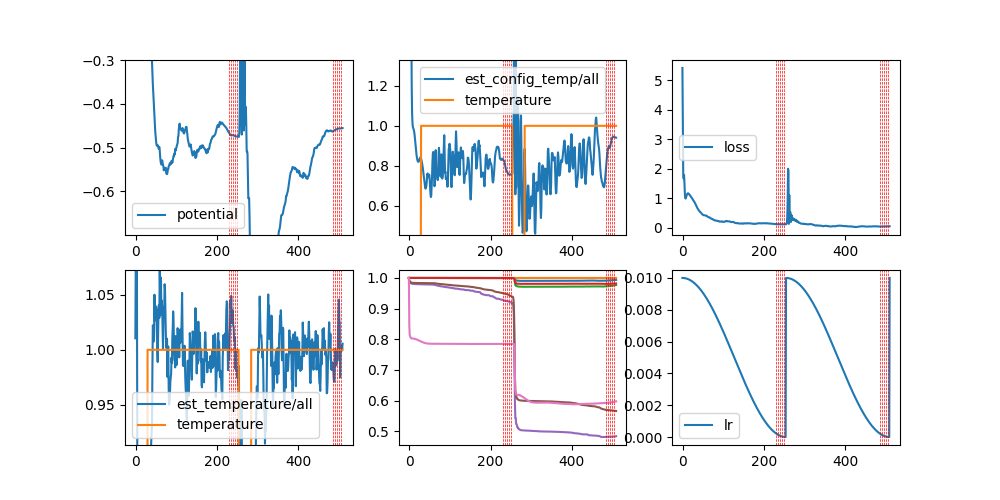

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

plot_metric(axes[0, 0], d, 'potential', iqr_ylim=2.)
plot_metric(axes[0, 1], d, 'est_config_temp/all', iqr_ylim=4.)
plot_metric(axes[0, 1], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all', iqr_ylim=2.)
plot_metric(axes[1, 0], d, 'temperature')
for k in d['preconditioner'].keys():
    plot_metric(axes[1, 1], d, f"preconditioner/{k}", legend=False)

plot_metric(axes[0, 2], d, 'loss')
plot_metric(axes[1, 2], d, 'lr')

for ax in axes.ravel():
    acceptance_vlines(ax, d)

fig.show()

In [35]:
d = read_metrics("/scratch/ag919/logs/BNN-priors/74")
d.keys()

<KeysViewHDF5 ['est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'timestamps']>

<IPython.core.display.Javascript object>


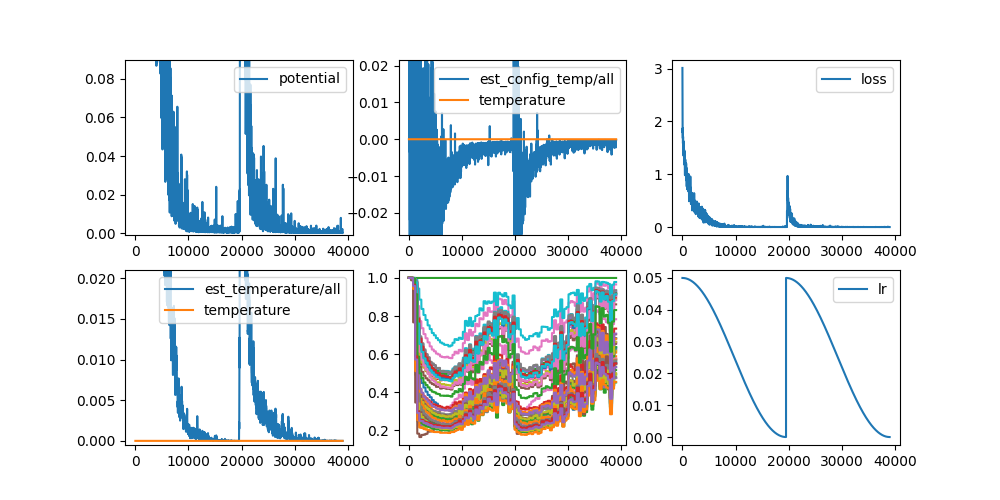

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
plot_metric(axes[0, 0], d, 'potential', iqr_ylim=4.)
plot_metric(axes[0, 1], d, 'est_config_temp/all', iqr_ylim=4.)
plot_metric(axes[0, 1], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all', iqr_ylim=2.)
plot_metric(axes[1, 0], d, 'temperature')
for k in d['preconditioner'].keys():
    plot_metric(axes[1, 1], d, f"preconditioner/{k}", legend=False)

plot_metric(axes[0, 2], d, 'loss')
plot_metric(axes[1, 2], d, 'lr')

fig.show()

In [81]:
idx = (d['lr'][:] == np.nanmin(d['lr']))
idx, = np.where(idx)

In [80]:
d = read_metrics("/scratch/ag919/logs/BNN-priors/4")
d.keys()

<KeysViewHDF5 ['acceptance', 'delta_energy', 'est_config_temp', 'est_temperature', 'log_prior', 'loss', 'lr', 'potential', 'preconditioner', 'steps', 'temperature', 'timestamps', 'total_energy']>

<IPython.core.display.Javascript object>


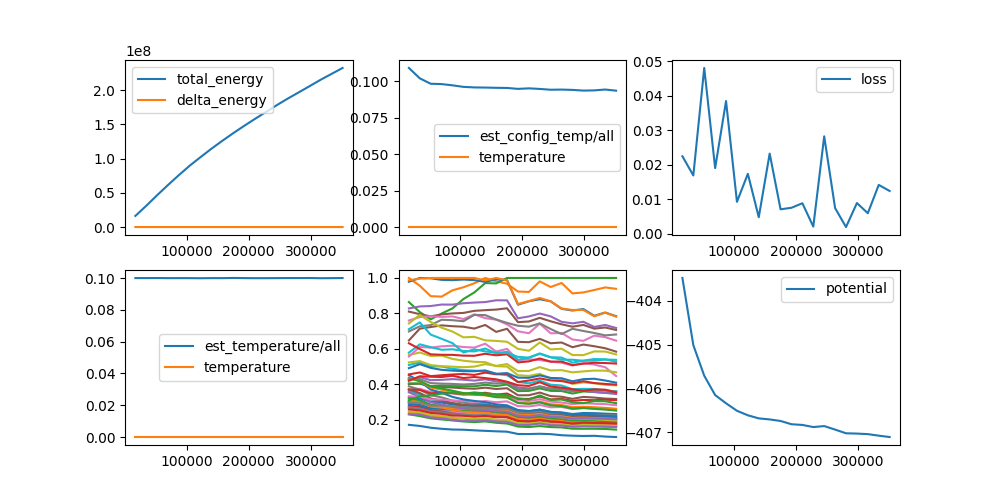

In [84]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
plot_metric(axes[0, 0], d, 'total_energy')
plot_metric(axes[0, 0], d, 'delta_energy')
plot_metric(axes[0, 1], d, 'est_config_temp/all')
plot_metric(axes[0, 1], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all')
plot_metric(axes[1, 0], d, 'temperature')
for k in d['preconditioner'].keys():
    plot_metric(axes[1, 1], d, f"preconditioner/{k}", legend=False)

plot_metric(axes[0, 2], d, 'loss')
plot_metric(axes[1, 2], d, 'potential')

fig.show()

In [60]:
d['steps'][:]

array([                   0,                    1,                    2,
       ..., -9223372036854775808, -9223372036854775808,
       -9223372036854775808])

# OurHMC metrics

Produced with
```bash
python experiments/train_bnn.py -D with model=test_gaussian warmup=0 \
    burnin=0 n_samples=300 inference=OurHMC momentum=1.0 lr=10.0
```

Note that loss=temperature because we're sampling from a Gaussian.

In [ ]:
d = read_metrics("../logs/57")
d.keys()

In [ ]:
_, axes = plt.subplots(2, 3, figsize=(15, 8))
plot_metric(axes[0, 0], d, 'acceptance/log_prob')
plot_metric(axes[0, 1], d, 'est_config_temp/all')
plot_metric(axes[0, 1], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all')
plot_metric(axes[1, 0], d, 'temperature')
plot_metric(axes[1, 1], d, 'acceptance/rejected')

plot_metric(axes[0, 2], d, 'loss')
plot_metric(axes[1, 2], d, 'lr')

# SGLD metrics

Produced with
```bash
python experiments/train_bnn.py -D with model=test_gaussian warmup=0 \
    burnin=0 n_samples=300 inference=SGLD momentum=0.6 lr=10.0
```

In [ ]:
d = read_metrics("../logs/52")
d.keys()

In [ ]:
_, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_metric(axes[0, 0], d, 'est_config_temp/all')
plot_metric(axes[0, 0], d, 'temperature')
plot_metric(axes[1, 0], d, 'est_temperature/all')
plot_metric(axes[1, 0], d, 'temperature')

plot_metric(axes[0, 1], d, 'loss')
plot_metric(axes[1, 1], d, 'lr')